## Mentorship: Time to Ask a Question

This notebook digs into the following questions:

1. What proportion of newcomers with access to a mentor asks their mentor a question (within 15 days of registration)?
2. Of those who ask their mentor at least one question, how many asks multiple questions?
3. Of those who ask their mentor a question, how quickly after registration does this occur?

We're interested in understanding this both across an entire wiki, as well as split by platform of registration, and responses to the Welcome Survey.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Path to the dataset with user information
user_dataset_filename <- here('datasets', 'mentorship_users.tsv')

## Column types in the user info dataset:
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
user_dataset_column_types <- 'ficffiiflldd'

## Path to the dataset with Welcome Survey responses
survey_dataset_filename <- here('datasets', 'mentorship_survey_responses.tsv')

## Column types in the survey response dataset
survey_dataset_column_types <- 'fifffd'

## Path to the dataset with mentorship question edit data
mentor_edit_dataset_filename <- here('datasets', 'mentorship_edits.tsv')

## Column types in the mentorship question edit data
## We're skipping columns 8 & 9 because wiki_db and user_id are duplicated
mentor_edit_dataset_column_types <- 'ficffdd__iici'

# Data import and setup

In [4]:
user_data <- read_tsv(user_dataset_filename, col_types = user_dataset_column_types)

In [5]:
survey_data <- read_tsv(survey_dataset_filename, col_types = survey_dataset_column_types)

In [6]:
## Note: we use "minimal" name repair because the column specification drops
## the two duplicated columns, otherwise they'd be renamed automatically.
mentoredits_data <- read_tsv(mentor_edit_dataset_filename,
                             col_types = mentor_edit_dataset_column_types,
                             name_repair = 'minimal')

In [7]:
nrow(user_data)

[1] 133832

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_data %>%
    group_by(wiki_db, platform, mentor_enabled) %>%
    summarize(n = n())

We filter out users with `mentor_enabled` set to 2 because they're so few of them. I suspect they disabled mentorship themselves.

In [9]:
cleaned_user_data <- user_data |>
    filter(mentor_enabled < 2)

In [10]:
cleaned_user_data |>
    group_by(wiki_db, platform, mentor_enabled) |>
    summarize(n = n()) |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

`summarise()` has grouped output by 'wiki_db', 'platform'. You can override
using the `.groups` argument.


wiki_db platform mentor_enabled n     per_group perc
1 eswiki  desktop  0               5312 10736     49.5
2 eswiki  desktop  1               5424 10736     50.5
3 eswiki  mobile   0               4334  8569     50.6
4 eswiki  mobile   1               4235  8569     49.4
5 enwiki  desktop  0              63952 71998     88.8
6 enwiki  desktop  1               8046 71998     11.2
7 enwiki  mobile   0              37790 42514     88.9
8 enwiki  mobile   1               4724 42514     11.1

In [11]:
cleaned_user_data |>
    group_by(wiki_db, mentor_enabled) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

wiki_db mentor_enabled n      per_group perc
1 eswiki  0                9646  19305    50.0
2 eswiki  1                9659  19305    50.0
3 enwiki  0              101742 114512    88.8
4 enwiki  1               12770 114512    11.2

## Join user data and survey responses

Checking number of rows, I suspect we can do a straight join.

In [10]:
nrow(cleaned_user_data)

[1] 133817

In [11]:
nrow(survey_data)

[1] 133832

Straight join the data:

In [12]:
users_with_surveys <- cleaned_user_data |>
    inner_join(survey_data, by = c('wiki_db', 'user_id'))

## Aggregate mentor questions

We aggregate the mentor question dataset to count number of edits per user, then left join.

In [13]:
mentor_q_agg <- mentoredits_data |>
    group_by(wiki_db, user_id) |>
    summarize(n_mentor_edits = n(), .groups = 'keep')

In [14]:
users_with_surveys <- users_with_surveys |>
    left_join(mentor_q_agg, by = c('wiki_db', 'user_id')) |>
    replace_na(list(n_mentor_edits = 0))

## Proportion who asks a question

In [17]:
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    group_by(wiki_db, platform) |>
    summarize(n_users = n(), n_edits = sum(n_mentor_edits),
              min_edits = min(n_mentor_edits), max_edits = max(n_mentor_edits),
              mean_edits = mean(n_mentor_edits), median_edits = median(n_mentor_edits))

`summarise()` has grouped output by 'wiki_db'. You can override using the
`.groups` argument.


wiki_db platform n_users n_edits min_edits max_edits mean_edits median_edits
1 eswiki  desktop  5424    156     0         3         0.0288     0           
2 eswiki  mobile   4235    114     0         3         0.0269     0           
3 enwiki  desktop  8046    146     0         3         0.0181     0           
4 enwiki  mobile   4724    143     0         3         0.0303     0

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    ggplot(aes(x = n_mentor_edits, fill = platform)) +
        facet_grid(wiki_db ~ .) +
        geom_histogram(binwidth = 1, position = 'dodge')

In [110]:
prop_asking_mentor_agg <- users_with_surveys |>
    filter(mentor_enabled == 1) |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE)) |>
    group_by(wiki_db, platform, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    mutate(SE = sqrt(prob * (1 - prob) / per_group))
prop_asking_mentor_agg

wiki_db platform asked_mentor n    per_group perc  prob   SE     
1 eswiki  desktop  FALSE        5280 5424      97.35 0.9735 0.00218
2 eswiki  desktop   TRUE         144 5424       2.65 0.0265 0.00218
3 eswiki  mobile   FALSE        4130 4235      97.52 0.9752 0.00239
4 eswiki  mobile    TRUE         105 4235       2.48 0.0248 0.00239
5 enwiki  desktop  FALSE        7908 8046      98.28 0.9828 0.00145
6 enwiki  desktop   TRUE         138 8046       1.72 0.0172 0.00145
7 enwiki  mobile   FALSE        4596 4724      97.29 0.9729 0.00236
8 enwiki  mobile    TRUE         128 4724       2.71 0.0271 0.00236

In [69]:
71555 + 7921

[1] 79476

In [70]:
6999 + 7090

[1] 14089

In [27]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web')) |>
    group_by(wiki_name, platform_name, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE) |>
    ggplot(aes(x = platform_name, y = prob, fill = platform_name)) +
        labs(title = 'Mentorship question rate',
             x = 'Registration platform', y = 'Percent asking') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_manual(values = c('Desktop' = '#c0e6ff', 'Mobile web' = '#c3d8ef')) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.03)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.001, size = 5) +
        facet_grid(. ~ wiki_name)
ggsave(
    'mentorship-question-by-wiki-and-platform.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "print", bg = 'white')

Just the proportion by wiki:

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English')) |>
    group_by(wiki_name, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE)

### Multiple Questions

Of those who ask at least one question, what proportion asks multiple questions?

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & n_mentor_edits > 0) |>
    mutate(asked_multiple = ifelse(n_mentor_edits > 1, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English')) |>
    group_by(wiki_name, asked_multiple) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group)

In [ ]:
users_with_surveys |>
   filter(mentor_enabled == 1 & n_mentor_edits > 0) |>
    mutate(asked_multiple = ifelse(n_mentor_edits > 1, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English')) |>
    group_by(wiki_name, platform, asked_multiple) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_multiple == TRUE)

## Questions by survey response/abandon/skip

In [87]:
names(users_with_surveys)

[1] "wiki_db"           "user_id"           "user_registration"
 [4] "up_value"          "exp_group"         "bot_by_name"      
 [7] "bot_by_group"      "platform"          "isapi"            
[10] "isselfmade"        "hp_enabled"        "mentor_enabled"   
[13] "response"          "reason"            "edited"           
[16] "num_languages"     "n_mentor_edits"

In [ ]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English')) |>
    group_by(wiki_name, response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE)
#ggsave(
#    'mentorship-question-by-wiki-and-platform.png',
#    path = 'graphs',
#    width = 9, height = 6, units = "in", dpi = "print")

In [ ]:
# Give me wider plots, please
users_with_surveys |>
    filter(mentor_enabled == 1) |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English')) |>
    group_by(wiki_name, platform, response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE)
#ggsave(
#    'mentorship-question-by-wiki-and-platform.png',
#    path = 'graphs',
#    width = 9, height = 6, units = "in", dpi = "print")

## Questions for users who responded to the survey

We start by checking question rates based on responses to the question "Have you edited Wikipedia before?" because we in NEWTEA Revisited found that it can be transformed into a "yes/no" answer.

In [176]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 12)
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    group_by(wiki_name, platform_name, edited_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(edited_response) == FALSE) |>
    ggplot(aes(x = edited_response, y = prob, fill = edited_response)) +
        labs(title = 'Editing response and question rate',
             x = 'Have you edited before?', y = 'Percent asking') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        scale_x_discrete(guide = guide_axis(angle = 90)) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.12)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(platform_name ~ wiki_name)
ggsave(
    'mentorship-asking-by-did-you-edit-before.png',
    path = 'graphs',
    width = 16, height = 12, units = "in", dpi = "print")

In table format, please:

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    group_by(wiki_name, platform_name, edited_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(edited_response) == FALSE)

It's clear that there aren't specific patterns here like we saw in NEWTEA, meaning we can't really collapse this as we'd hoped for. We have very small counts in some of these buckets, so let's look at patterns in the other question instead.

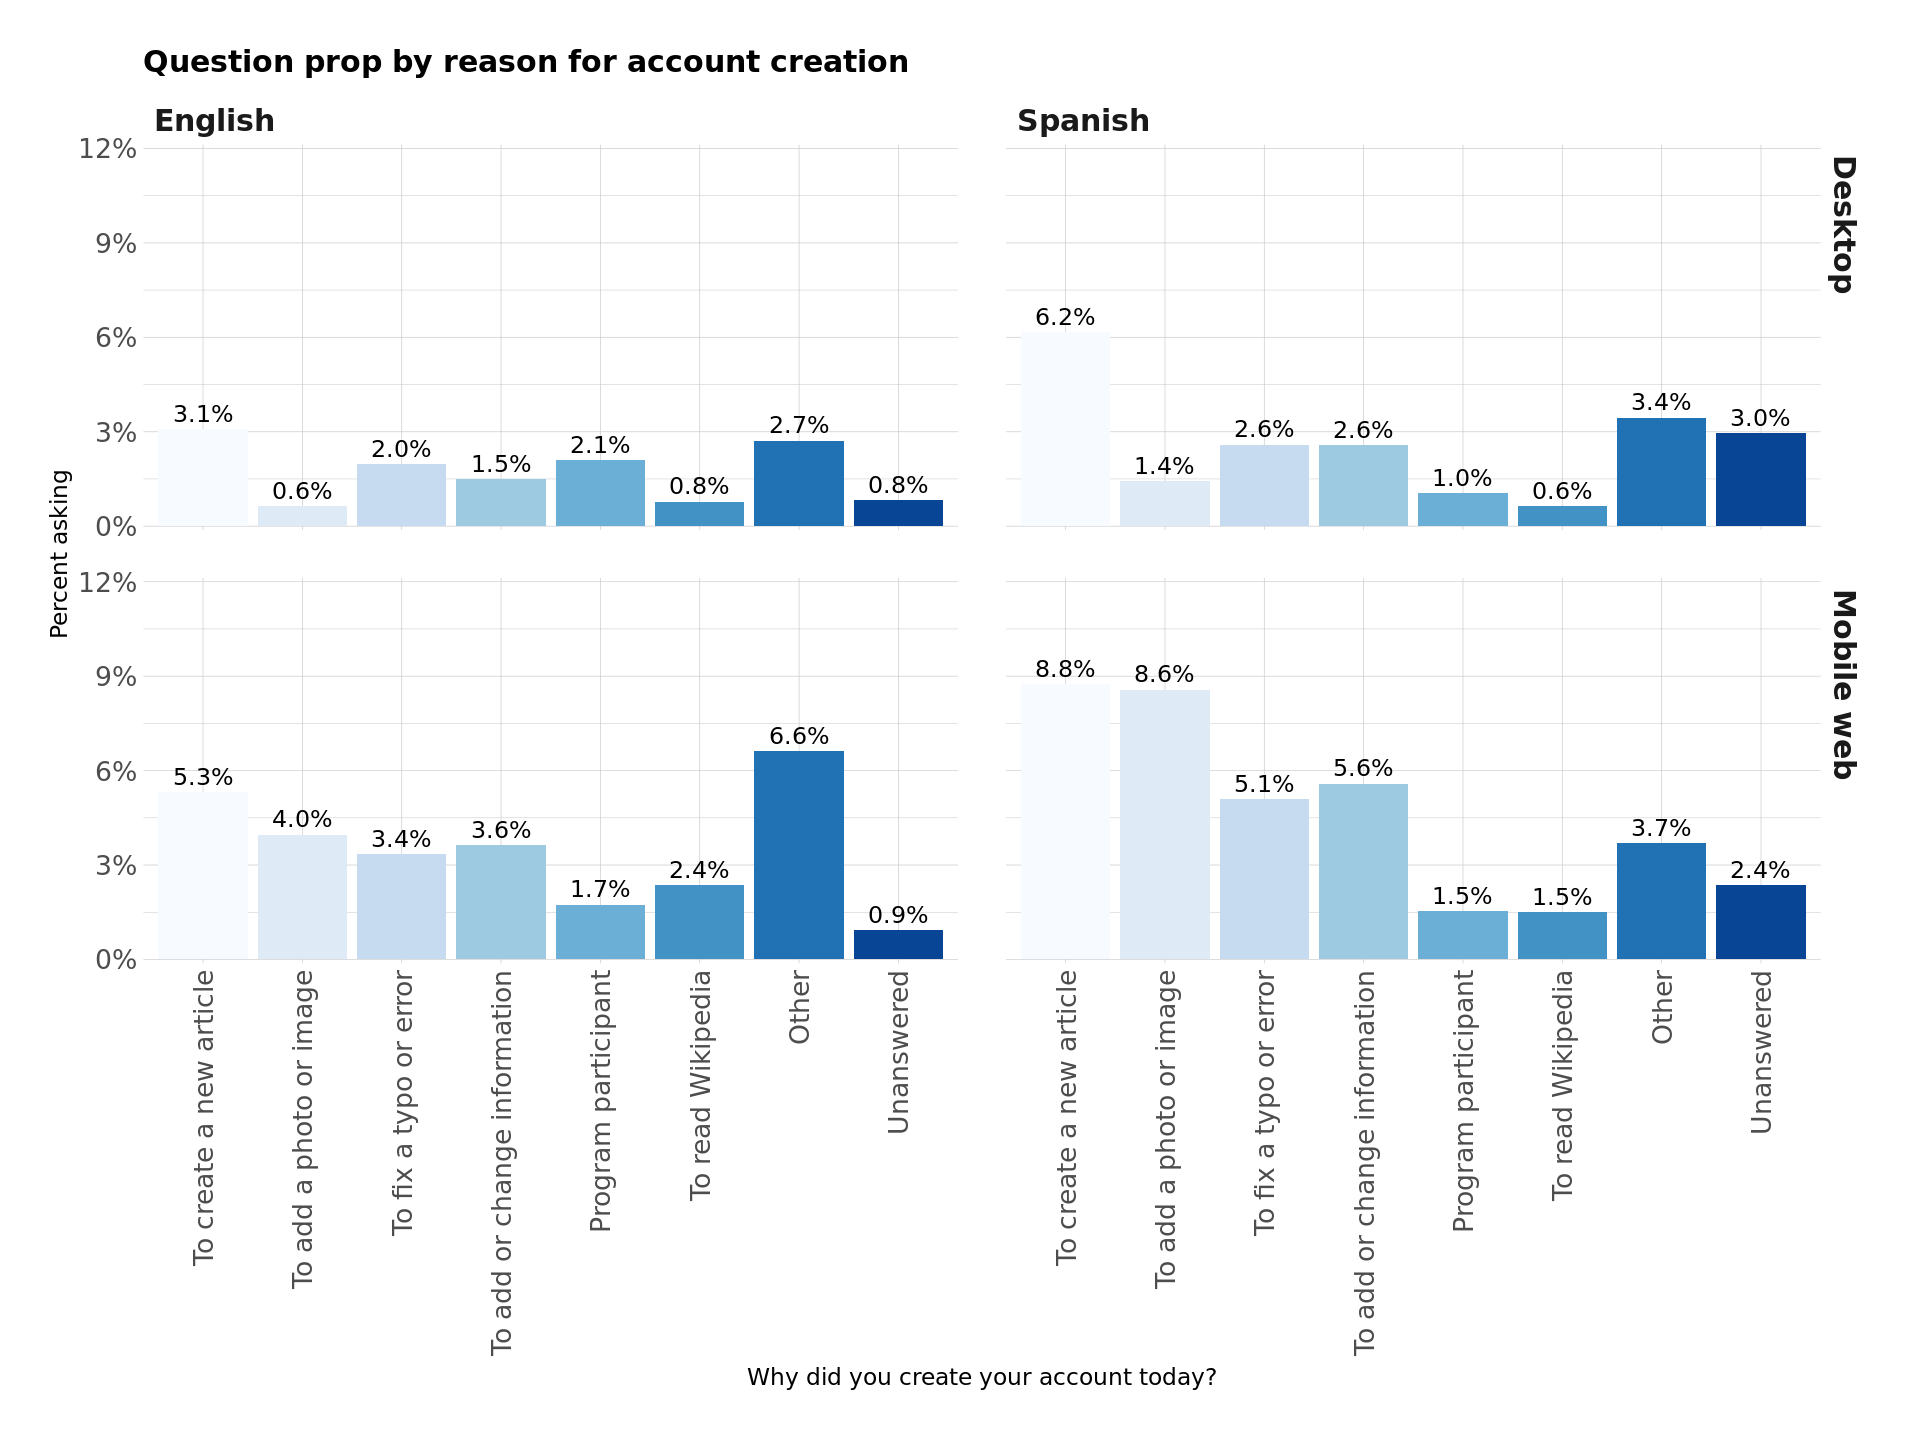

In [175]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 12)
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           reason_response = factor(
               reason,
               levels = c('new-page', 'add-image', 'edit-typo', 'edit-info-add-change', 'program-participant',
                          'read', 'other', 'placeholder'),
               labels = c("To create a new article", "To add a photo or image", "To fix a typo or error",
                          "To add or change information", "Program participant", "To read Wikipedia", "Other",
                          "Unanswered"))) |>
    group_by(wiki_name, platform_name, reason_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(reason_response) == FALSE) |>
    ggplot(aes(x = reason_response, y = prob, fill = reason_response)) +
        labs(title = 'Question prop by reason for account creation',
             x = 'Why did you create your account today?', y = 'Percent asking') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        scale_x_discrete(guide = guide_axis(angle = 90)) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.12)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(platform_name ~ wiki_name)
ggsave(
    'mentorship-asking-by-account-reason.png',
    path = 'graphs',
    width = 16, height = 12, units = "in", dpi = "print")

In table format:

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           reason_response = factor(
               reason,
               levels = c('new-page', 'add-image', 'edit-typo', 'edit-info-add-change', 'program-participant',
                          'read', 'other', 'placeholder'),
               labels = c("To create a new article", "To add a photo or image", "To fix a typo or error",
                          "To add or change information", "Program participant", "To read Wikipedia", "Other",
                          "Unanswered"))) |>
    group_by(wiki_name, platform_name, reason_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(reason_response) == FALSE)

## Investigation of users who edited asking questions

A large proportion of mobile web users on Spanish Wikipedia who responded that they'd edited many times were also asking their mentor a question. What kind of questions did they ask?

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    filter(wiki_db == 'eswiki' & platform == 'mobile' &
           asked_mentor == TRUE & edited == 'yes-many') |>
    select(user_id)

# Distribution of Time-to-Question

In [21]:
## We'll convert user_registration and rev_timestamp to date & time objects
## to make us able to calculate the difference

mentoredits_data <- mentoredits_data |>
    mutate(
        user_registration_ts = ymd_hms(user_registration),
        rev_ts = ymd_hms(rev_timestamp),
        time_to_mentor_q = rev_ts - user_registration_ts
    )

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'enwiki' & mentor_enabled == 1) |>
    ggplot(aes(x = as.numeric(time_to_mentor_q))) +
      geom_histogram(binwidth = 0.1, colour="black", fill='white') +
      ggtitle('Time to mentor question – English Wikipedia') +
      scale_x_log10(
          "Time",
          breaks = c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
          labels = c("minute", "15 min.", "hour", "day", "week", "month", "year"))

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'eswiki' & mentor_enabled == 1) |>
    ggplot(aes(x = as.numeric(time_to_mentor_q))) +
      geom_histogram(binwidth = 0.1, colour="black", fill='white') +
      ggtitle('Time to mentor question – Spanish Wikipedia') +
      scale_x_log10(
          "Time",
          breaks = c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
          labels = c("minute", "15 min.", "hour", "day", "week", "month", "year"))

## Time to first question

While most newcomers ask only one question, we'll limit the dataset to a single question. We'll also split this by platform to understand if there's a difference between desktop and mobile web.

### English

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'enwiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    summarize(diff_to_first_q = min(time_to_mentor_q), .groups = 'keep') |>
    ggplot(aes(x = as.numeric(diff_to_first_q))) +
      geom_histogram(binwidth = 0.3, colour="black", fill='white') +
      ggtitle('Time to mentor question – English Wikipedia') +
      scale_x_log10(
          "Time",
          breaks = c(60, 5*60, 15*60, 60*60, 3*60*60, 6*60*60, 12*60*60,
                     24*60*60, 7*24*60*60),
          labels = c("minute", "5m", "15m", "hour", "3h", "6h", "12h",
                     "day", "week"),
          limits = c(15, 15*24*60*60)) +
      facet_grid(. ~ platform)

### Spanish

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'eswiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    summarize(diff_to_first_q = min(time_to_mentor_q), .groups = 'keep') |>
    ggplot(aes(x = as.numeric(diff_to_first_q))) +
      geom_histogram(binwidth = 0.3, colour="black", fill='white') +
      ggtitle('Time to mentor question – Spanish Wikipedia') +
      scale_x_log10(
          "Time",
          breaks = c(60, 5*60, 15*60, 60*60, 3*60*60, 6*60*60, 12*60*60,
                     24*60*60, 7*24*60*60),
          labels = c("minute", "5m", "15m", "hour", "3h", "6h", "12h",
                     "day", "week"),
          limits = c(15, 15*24*60*60)) +
      facet_grid(. ~ platform)

I think these can be improved by also faceting by whether the mentor question is their first edit or not.

Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”


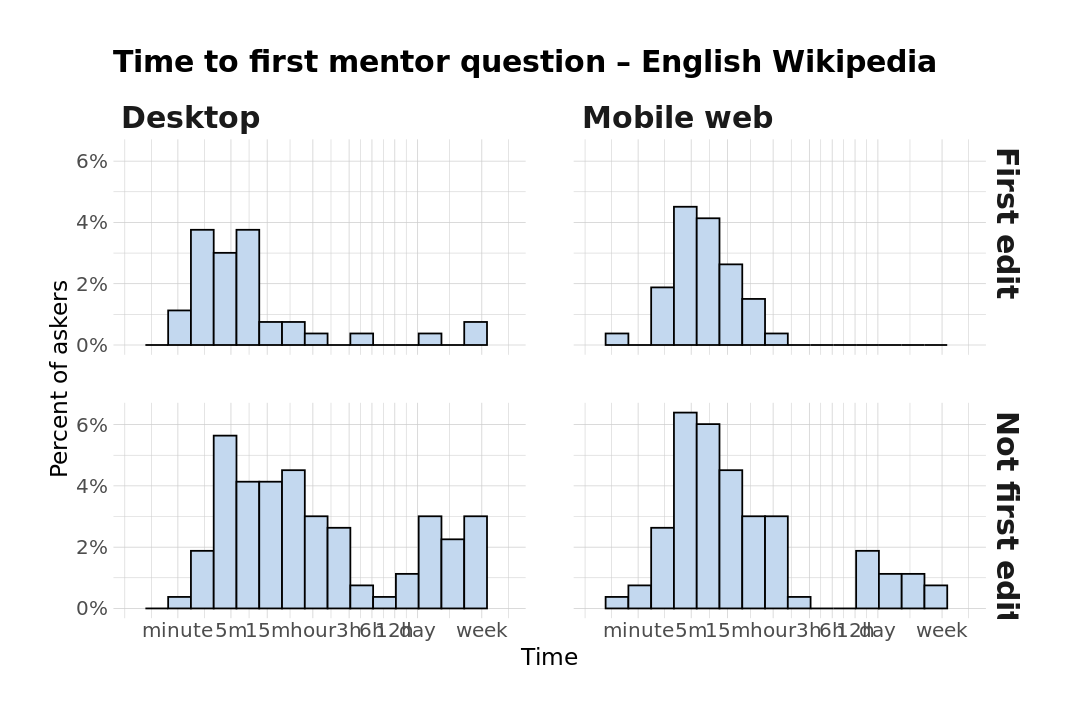

In [25]:
mentoredits_data |>
    filter(wiki_db == 'enwiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(
        mentor_q_first_edit = ifelse(user_edit_count == 0, "First edit", "Not first edit"),
        platform_name = ifelse(platform == 'mobile', 'Mobile web', 'Desktop')
    ) |>
    ggplot(aes(x = as.numeric(time_to_mentor_q))) +
        ggtitle('Time to first mentor question – English Wikipedia') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 12, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        scale_y_continuous("Percent of askers", labels = scales::percent) +
        scale_x_log10(
            "Time",
            breaks = c(60, 5*60, 15*60, 60*60, 3*60*60, 6*60*60, 12*60*60,
                       24*60*60, 7*24*60*60),
            labels = c("minute", "5m", "15m", "hour", "3h", "6h", "12h",
                       "day", "week"),
            limits = c(15, 15*24*60*60)) +
        geom_histogram(aes(y = after_stat(count / sum(count))), binwidth = 0.3,
                       color = 'black', fill = '#c3d8ef') +
        facet_grid(mentor_q_first_edit ~ platform_name)
ggsave(
    'mentorship-time-to-first-enwiki.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = 'white')

Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”


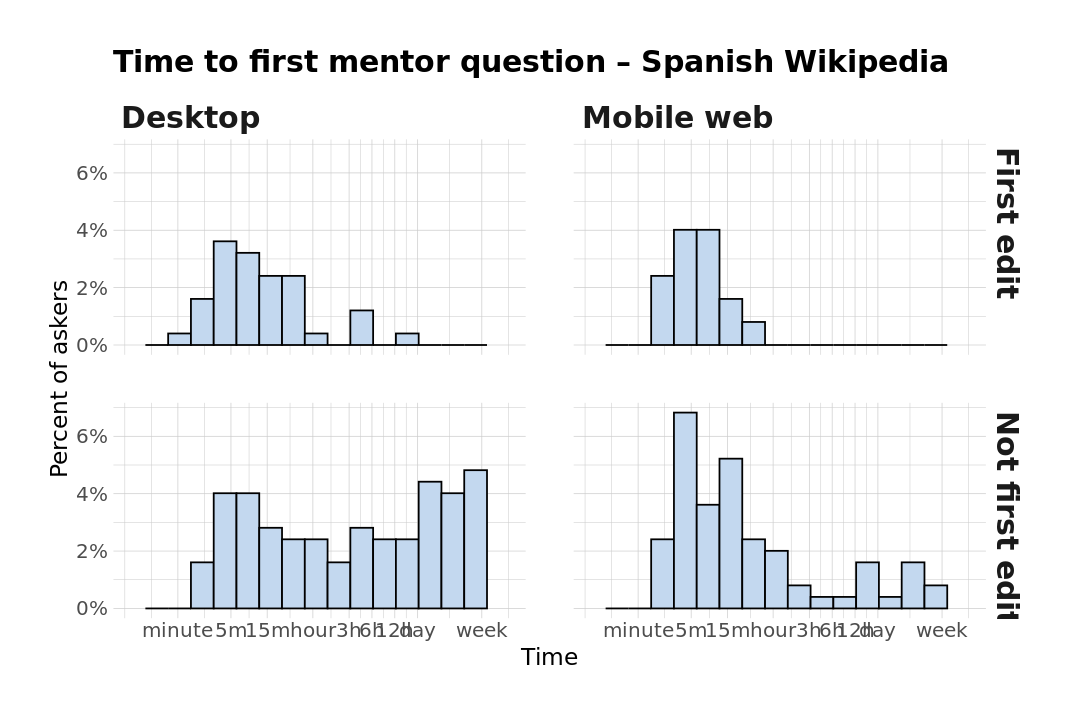

In [26]:
mentoredits_data |>
    filter(wiki_db == 'eswiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(
        mentor_q_first_edit = ifelse(user_edit_count == 0, "First edit", "Not first edit"),
        platform_name = ifelse(platform == 'mobile', 'Mobile web', 'Desktop')
    ) |>
    ggplot(aes(x = as.numeric(time_to_mentor_q))) +
        ggtitle('Time to first mentor question – Spanish Wikipedia') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 12, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        scale_y_continuous("Percent of askers", labels = scales::percent) +
        scale_x_log10(
            "Time",
            breaks = c(60, 5*60, 15*60, 60*60, 3*60*60, 6*60*60, 12*60*60,
                       24*60*60, 7*24*60*60),
            labels = c("minute", "5m", "15m", "hour", "3h", "6h", "12h",
                       "day", "week"),
            limits = c(15, 15*24*60*60)) +
        geom_histogram(aes(y = after_stat(count / sum(count))), binwidth = 0.3,
                       colour="black", fill='#c3d8ef') +
        facet_grid(mentor_q_first_edit ~ platform_name)
ggsave(
    'mentorship-time-to-first-eswiki.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = 'white')

# Editcount at Question Time

In [106]:
mentoredits_data |>
    filter(wiki_db == 'enwiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    group_by(wiki_db, platform) |>
    summarize(mean_edit_count = mean(user_edit_count),
              q25_edit_count = quantile(user_edit_count, 0.25),
              median_edit_count = median(user_edit_count),
              q75_edit_count = quantile(user_edit_count, 0.75),
              q90_edit_count = quantile(user_edit_count, 0.9),
              q95_edit_count = quantile(user_edit_count, 0.95),
              q99_edit_count = quantile(user_edit_count, 0.99),
              .groups = 'keep')

wiki_db platform mean_edit_count q25_edit_count median_edit_count
1 enwiki  desktop  2.7             0              1                
2 enwiki  mobile   1.7             0              1                
  q75_edit_count q90_edit_count q95_edit_count q99_edit_count
1 2              6.3            9.30           16.8          
2 1              4.0            7.65           13.7

In [107]:
mentoredits_data |>
    filter(wiki_db == 'eswiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    group_by(wiki_db, platform) |>
    summarize(mean_edit_count = mean(user_edit_count),
              q25_edit_count = quantile(user_edit_count, 0.25),
              median_edit_count = median(user_edit_count),
              q75_edit_count = quantile(user_edit_count, 0.75),
              q90_edit_count = quantile(user_edit_count, 0.9),
              q95_edit_count = quantile(user_edit_count, 0.95),
              q99_edit_count = quantile(user_edit_count, 0.99),
              .groups = 'keep')

wiki_db platform mean_edit_count q25_edit_count median_edit_count
1 eswiki  desktop  6.48            0              1                
2 eswiki  mobile   2.18            0              1                
  q75_edit_count q90_edit_count q95_edit_count q99_edit_count
1 4              9.0            15.5           94.1          
2 2              3.6             5.0           24.7

So the majority of newcomers who ask their mentor a question have made at least one edit. Let's figure out what proportion of newcomers on each wiki had no other edits at the time of asking.

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'enwiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(mentor_q_first_edit = ifelse(user_edit_count == 0, TRUE, FALSE)) |>
    group_by(wiki_db, platform, mentor_q_first_edit) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group)

In [ ]:
mentoredits_data |>
    filter(wiki_db == 'eswiki' & mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(mentor_q_first_edit = ifelse(user_edit_count == 0, TRUE, FALSE)) |>
    group_by(wiki_db, platform, mentor_q_first_edit) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group)

We're looking at around one third of newcomers who ask their mentor a question doing so on their *first* edit, so like about 1% of all new registrations.

In [ ]:
prop_asking_first_edit_agg <- mentoredits_data |>
    filter(mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(mentor_q_first_edit = ifelse(user_edit_count == 0, TRUE, FALSE)) |>
    group_by(wiki_db, platform, mentor_q_first_edit) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group)
prop_asking_first_edit_agg

In [122]:
prop_asking_first_edit_counts <- prop_asking_first_edit_agg |>
    filter(mentor_q_first_edit == TRUE) |>
    select(wiki_db, platform, n) |>
    rename(n_q_first_edit = n)

In [ ]:
prop_asking_mentor_agg |>
    filter(asked_mentor == TRUE) |>
    rename(n_asked_mentor = n) |>
    inner_join(prop_asking_first_edit_counts, by = c('wiki_db', 'platform')) |>
    mutate(
        perc_q_first_edit_of_askers = 100.0 * n_q_first_edit / n_asked_mentor,
        perc_q_first_edit_of_all = 100.0 * n_q_first_edit / per_group)

In [159]:
mentoredits_data |>
    filter(mentor_enabled == 1) |>
    group_by(wiki_db, platform, user_id) |>
    arrange(rev_timestamp, .by_group = TRUE) |>
    filter(row_number() == 1) |>
    mutate(mentor_q_first_edit = ifelse(user_edit_count == 0, TRUE, FALSE)) |>
    filter(platform == 'mobile' & mentor_q_first_edit == TRUE &
            time_to_mentor_q != 1246449) |>
    group_by(wiki_db) |>
    summarize(max_time_diff = max(time_to_mentor_q)) |>
    mutate(max_time_m = as.numeric(max_time_diff) / 60)

wiki_db max_time_diff max_time_m
1 enwiki  3273 secs     54.5      
2 eswiki  2283 secs     38.0